In [1]:
import glob
import os
from random import shuffle
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from tensorflow import keras
word_vector=KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin',binary=True)

def pre_process_data(filepath):
    positive_path=os.path.join(filepath,'pos')
    negative_path=os.path.join(filepath,'neg')
    pos_label=1
    neg_label=0
    dataset=[]
    for filename in glob.glob(os.path.join(positive_path,'*.txt')):
        dataset.append((pos_label,filename))
    for filename in glob.glob(os.path.join(negative_path,'*.txt')):
        dataset.append((neg_label,filename))
    shuffle(dataset)
    return dataset

dataset=pre_process_data('data/aclImdb/train')
split_point=int(len(dataset)*0.8)
trainData=dataset[:split_point]
testData=dataset[split_point:]
tokenizer=TreebankWordTokenizer()

print(dataset[:5])
trainlen=len(trainData)
testlen=len(testData)

def token_and_vectorize(filename,tokenizers):
    sample_vec=[]
    with open(filename,'r') as f:
        tokens=tokenizer.tokenize(f.read())
        for token in tokens:
            try:
                sample_vec.append(word_vector[token])
            except:
                pass
    return sample_vec

def pad_trunc(data,maxlen=400):
    zero_vector=[]
    for _ in range(len(data[0])):
        zero_vector.append(0.0)
    if len(data)>maxlen:
        temp=data[:maxlen]
    elif len(data)<maxlen:
        temp=data
        additional_elems=maxlen-len(data)
        for _ in range(additional_elems):
            temp.append(zero_vector)
    else:
        temp=data
    return temp

maxlen=400
batch_size=32
embedding_dims=300
filtes=250
kernel_size=3
hidden_dims=250
epochs=10

[(1, 'data/aclImdb/train/pos/693_10.txt'), (0, 'data/aclImdb/train/neg/6406_4.txt'), (1, 'data/aclImdb/train/pos/5133_10.txt'), (1, 'data/aclImdb/train/pos/7697_9.txt'), (1, 'data/aclImdb/train/pos/9632_8.txt')]


In [2]:
s=[]
with open(dataset[0][1],'r') as f:
    tokens=tokenizer.tokenize(f.read())
    for token in tokens:
        try:
            s.append(word_vector[token])
        except:
            pass
s=token_and_vectorize(dataset[0][1],tokenizer)
sd=pad_trunc(s,maxlen=400)
len(sd)

400

In [5]:
def data_generator(data_store,tokenizers,batchsize=32,maxlen=400,embedding_dims=300):
    X,Y=[],[]
    while True:
        for i in range(len(data_store)):
            if i % batchsize==0 and X and Y:
                X=np.reshape(X,(len(X),maxlen,embedding_dims))
                Y=np.array(Y)
                yield X,Y
                X,Y=[],[]
            x,y=data_store[i][1],data_store[i][0]
            x=pad_trunc(token_and_vectorize(x,tokenizers),maxlen=maxlen)    
            X.append(x)
            Y.append(y)

In [6]:
def data_generator_second(data_store,tokenizers,batchsize=32,maxlen=400,embedding_dims=300):
    X,Y=[],[]
    while True:
        for i in range(len(data_store)):
            if (i % batchsize==0 and X and Y) or (i==len(data_store)):
                X=np.reshape(X,(len(X),maxlen,embedding_dims))
                Y=np.array(Y)
                yield X,Y
                X,Y=[],[]
            x,y=data_store[i][1],data_store[i][0]
            x=pad_trunc(token_and_vectorize(x,tokenizers),maxlen=maxlen)    
            X.append(x)
            Y.append(y)


In [7]:

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Conv1D,GlobalMaxPool1D
model=Sequential()
model.add(Conv1D(filtes,kernel_size,padding='valid',activation='relu',strides=1,input_shape=(maxlen,embedding_dims)))
model.add(GlobalMaxPool1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
#输出层
model.add(Dense(1))
model.add(Activation('sigmoid'))
#编译
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
X_test=data_generator_second(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)

In [10]:
import math
# model.fit_generator(generator=data_generator_second(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=2,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))
history=model.fit(data_generator_second(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=10,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Epoch 1/10
625/625 [==============================] - 104s 158ms/step - loss: 0.4880 - accuracy: 0.7437 - val_loss: 0.3097 - val_accuracy: 0.8706
Epoch 2/10
625/625 [==============================] - 92s 147ms/step - loss: 0.2766 - accuracy: 0.8838 - val_loss: 0.2907 - val_accuracy: 0.8774
Epoch 3/10
625/625 [==============================] - 92s 147ms/step - loss: 0.1722 - accuracy: 0.9367 - val_loss: 0.4942 - val_accuracy: 0.8268
Epoch 4/10
625/625 [==============================] - 91s 146ms/step - loss: 0.1637 - accuracy: 0.9319 - val_loss: 0.5000 - val_accuracy: 0.8428
Epoch 5/10
625/625 [==============================] - 91s 146ms/step - loss: 0.1216 - accuracy: 0.9509 - val_loss: 0.4742 - val_accuracy: 0.8704
Epoch 6/10
625/625 [==============================] - 91s 145ms/step - loss: 0.0809 - accuracy: 0.9688 - val_loss: 0.5613 - val_accuracy: 0.8632
Epoch 7/10
625/625 [==============================] - 91s 145ms/step - loss: 0.0660 - accuracy: 0.9758 - val_loss: 0.5208 - val_a

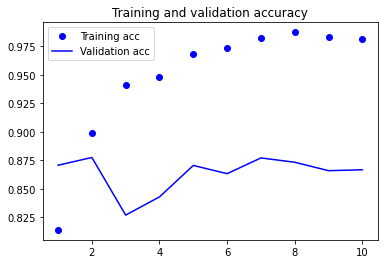

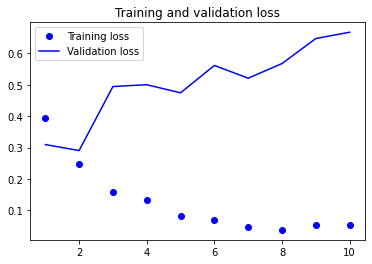

In [18]:
# ! pip install matplotlib

import matplotlib.pyplot as plt

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("data/filename.png")
plt.show()


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 398, 250)          225250    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
activation (Activation)      (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

In [19]:
m_s=model.to_json()
with open('data/cnn_model.json','w') as json_file:
    json_file.write(m_s)
# model.save('data/cnn_model.h5')

In [20]:
model.save_weights('data/cnn_weights.h5')
# new_model=keras.models.load_model('data/cnn_model.h5')

In [2]:
from tensorflow.keras.models import model_from_json

In [3]:
with open('data/cnn_model.json','r') as json_file:
    j_s=json_file.read()


In [4]:
model1=model_from_json(j_s)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 398, 250)          225250    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
activation (Activation)      (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

In [5]:
model1.load_weights('data/cnn_weights.h5')

In [9]:
def token_and_vectorize_str(strString,tokenizers):
    sample_vec=[]
    tokens=tokenizer.tokenize(strString)
    for token in tokens:
        try:
            sample_vec.append(word_vector[token])
        except:
            pass
    return sample_vec
sample_1="I hate that the dismal weather had me down for so long,when will it break! Ugh, when does happiness return? The sun is blinding and the puffy clouds are too thin. I can't wait for the weekend."
test_vec=pad_trunc(token_and_vectorize_str(sample_1,tokenizer),maxlen=maxlen)
test_vec=np.reshape(test_vec,(1,400,300))

In [10]:
len(test_vec)

1

In [32]:
test_vec.shape

(1, 400, 300)

In [11]:
model1.predict(test_vec)

array([[0.00366375]], dtype=float32)

In [12]:
model1.predict_classes(test_vec)

array([[0]], dtype=int32)